### Running through some examples discussed in the lectures with python

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt

In [4]:
def potential_outcome(xi, ti):
    return ti * (np.abs((xi[0] + xi[1])) - .05)  + (1 - ti) * np.abs((xi[0] + xi[2])) 

def propensity_score(X):
    return 1 / (1 + np.exp(-X[:,0]))

### Cross Fitting

In [74]:
def cross_fit_predict(model, X, y, pred_batch_size = 1, binary_model = False):
    """Takes a prediction model and iteratively cross fit on training data with prediction batch left out.
    Deterministic ordering ; assume that training data has already been shuffled randomly."""
    n_batch = int(np.ceil(len(X) / pred_batch_size))
    preds = []
    for n in range(n_batch) : 
        X_pred = X[n * pred_batch_size : n * pred_batch_size + pred_batch_size]
        X_train = np.append(X[0 : n * pred_batch_size], X[n * pred_batch_size + pred_batch_size ::], axis = 0)
        y_train = np.append(y[0 : n * pred_batch_size], y[n * pred_batch_size + pred_batch_size ::])
        model.fit(X_train, y_train)
        if binary_model:
            preds.extend(model.predict_proba(X_pred)[:,1].reshape(-1))
        else:
            preds.extend(model.predict(X_pred).reshape(-1))
    return preds

##### Constant propensity score

In [5]:
#Constant propensity score
n_sim = 50000
X = np.random.randn(n_sim,3)
T = np.random.binomial(1, .5, size = n_sim)
outcomes = np.array([potential_outcome(xi, ti) for xi,ti in zip(X, T)])
print(np.mean(outcomes[np.argwhere(T == 1).reshape(-1)]) - np.mean(outcomes[np.argwhere(T == 0).reshape(-1)]))

-0.05932054601752923


#### With Confounding

### AIPW

#### Regression adjustment estimator

In [82]:
#With confounding
n_sim = 1000
tau_est = []
p = 20
for n in range(2):
    X = np.random.randn(n_sim,p)
    T = np.random.binomial(1, propensity_score(X))
    outcomes = np.array([potential_outcome(xi, ti) for xi,ti in zip(X, T)])
    df = pd.DataFrame(columns = [f"x{i}" for i in range(p)], data = X)
    df['T'] = T
    df['Y'] = outcomes
    ### random forest for separate potential outcomes u_1(X) and u_2(X)
    ##out-of-the-box random forest model
    for t in [0, 1]:
        mask_t = df['T'] == t
        preds = cross_fit_predict(RandomForestRegressor(),
                                  X = df.loc[mask_t].values[:,0:p],
                                  y = df.loc[mask_t].Y.values,
                                  pred_batch_size = 50)
        df.loc[mask_t, f'mu_hat{t}'] = preds
        X_unobs = df.loc[~mask_t].values[:, 0:p]
        preds_unobs = (RandomForestRegressor().
                             fit(X = df.loc[mask_t].values[:,0:p], y = df.loc[mask_t].Y.values).
                             predict(X_unobs).reshape(-1))
        df.loc[~mask_t, f'mu_hat{t}'] = preds_unobs
        

In [83]:
np.mean(df.mu_hat1 - df.mu_hat0)

-0.04146168805792007

#### Add in IPW applied to residuals

##### Propensity score estimator

In [104]:
ehat_preds = cross_fit_predict(RandomForestClassifier(), X = X, y = T, binary_model = True,
                         pred_batch_size = 50)
df['ehat_pred'] = ehat_preds

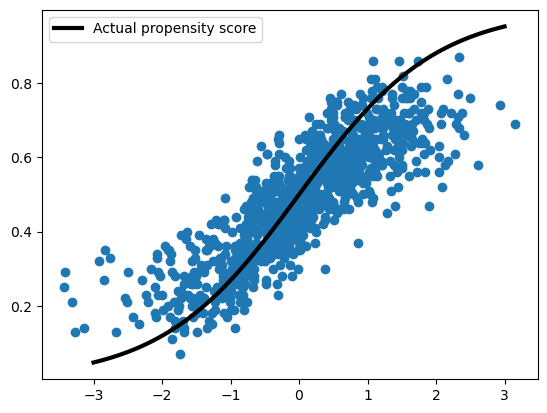

In [95]:
fig,ax = plt.subplots()
ax.scatter(X[:,0], ehat_preds)
xp = np.linspace(-3, 3, 100)
ax.plot(xp, propensity_score(xp.reshape(-1,1)),color = 'k',linewidth = 3, label = 'Actual propensity score')
ax.legend()

In [105]:
df.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'T', 'Y',
       'mu_hat0', 'mu_hat1', 'ehat_pred'],
      dtype='object')

In [107]:
def resid_ipw(x):
    return ((x['T']/x['ehat_pred']) * (x['Y'] - x['mu_hat1'])) - (((1 - x['T'])/(1 - x['ehat_pred'])) * (x['Y'] - x['mu_hat0']))
df['R'] = df.apply(lambda x : resid_ipw(x), axis = 1)

### Final AIPW estimator for ATE (compare to actual of -.05)

In [113]:
aipw = np.mean(df['mu_hat1'] - df['mu_hat0'] + df['R'])
aipw

-0.05170306472513528